In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Fri Jan 12 15:08:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              N/A / ERR! |    512MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
num_heads = 12
equation_name = "VDP"

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (1, 2)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[0., -1.], [1., alpha]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[1, 3], y_bound=[0, 0]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
IC_list = [random_IC() for i in range(num_heads)]
#IC_list = [torch.tensor([[2.], [0.]], device=dev).double() for _ in range(num_heads)]

# training force (random or not)
def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = -np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev)
#force_list = [random_force() for i in range(num_heads)]
force_list = [torch.tensor([[0.], [0.]], device=dev).double() for _ in range(num_heads)]

C:\Users\Emilien\AppData\Local\Temp\ipykernel_9428\1984622760.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([ICx, ICy], device=dev)


In [9]:
x_range = [0, 1]
activation = "tanh"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 2
iterations = 1000

In [10]:
sample_size = 200
lr = 0.00005
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr,
                                                           A_list=A_list, v_list=IC_list, force=force_list,
                                                           hid_lay=hid_lay, activation=activation,
                                                           num_equations=num_equations, num_heads=num_heads,
                                                           sample_size = sample_size, decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 2/1000 [00:00<01:22, 12.04it/s]

Iterations 0: loss = 2.0734742438968823


 50%|█████     | 502/1000 [00:45<00:39, 12.73it/s]

Iterations 500: loss = 0.036462781188391025


100%|██████████| 1000/1000 [01:30<00:00, 11.08it/s]

Model Training Complete in 90.289 seconds


In [11]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

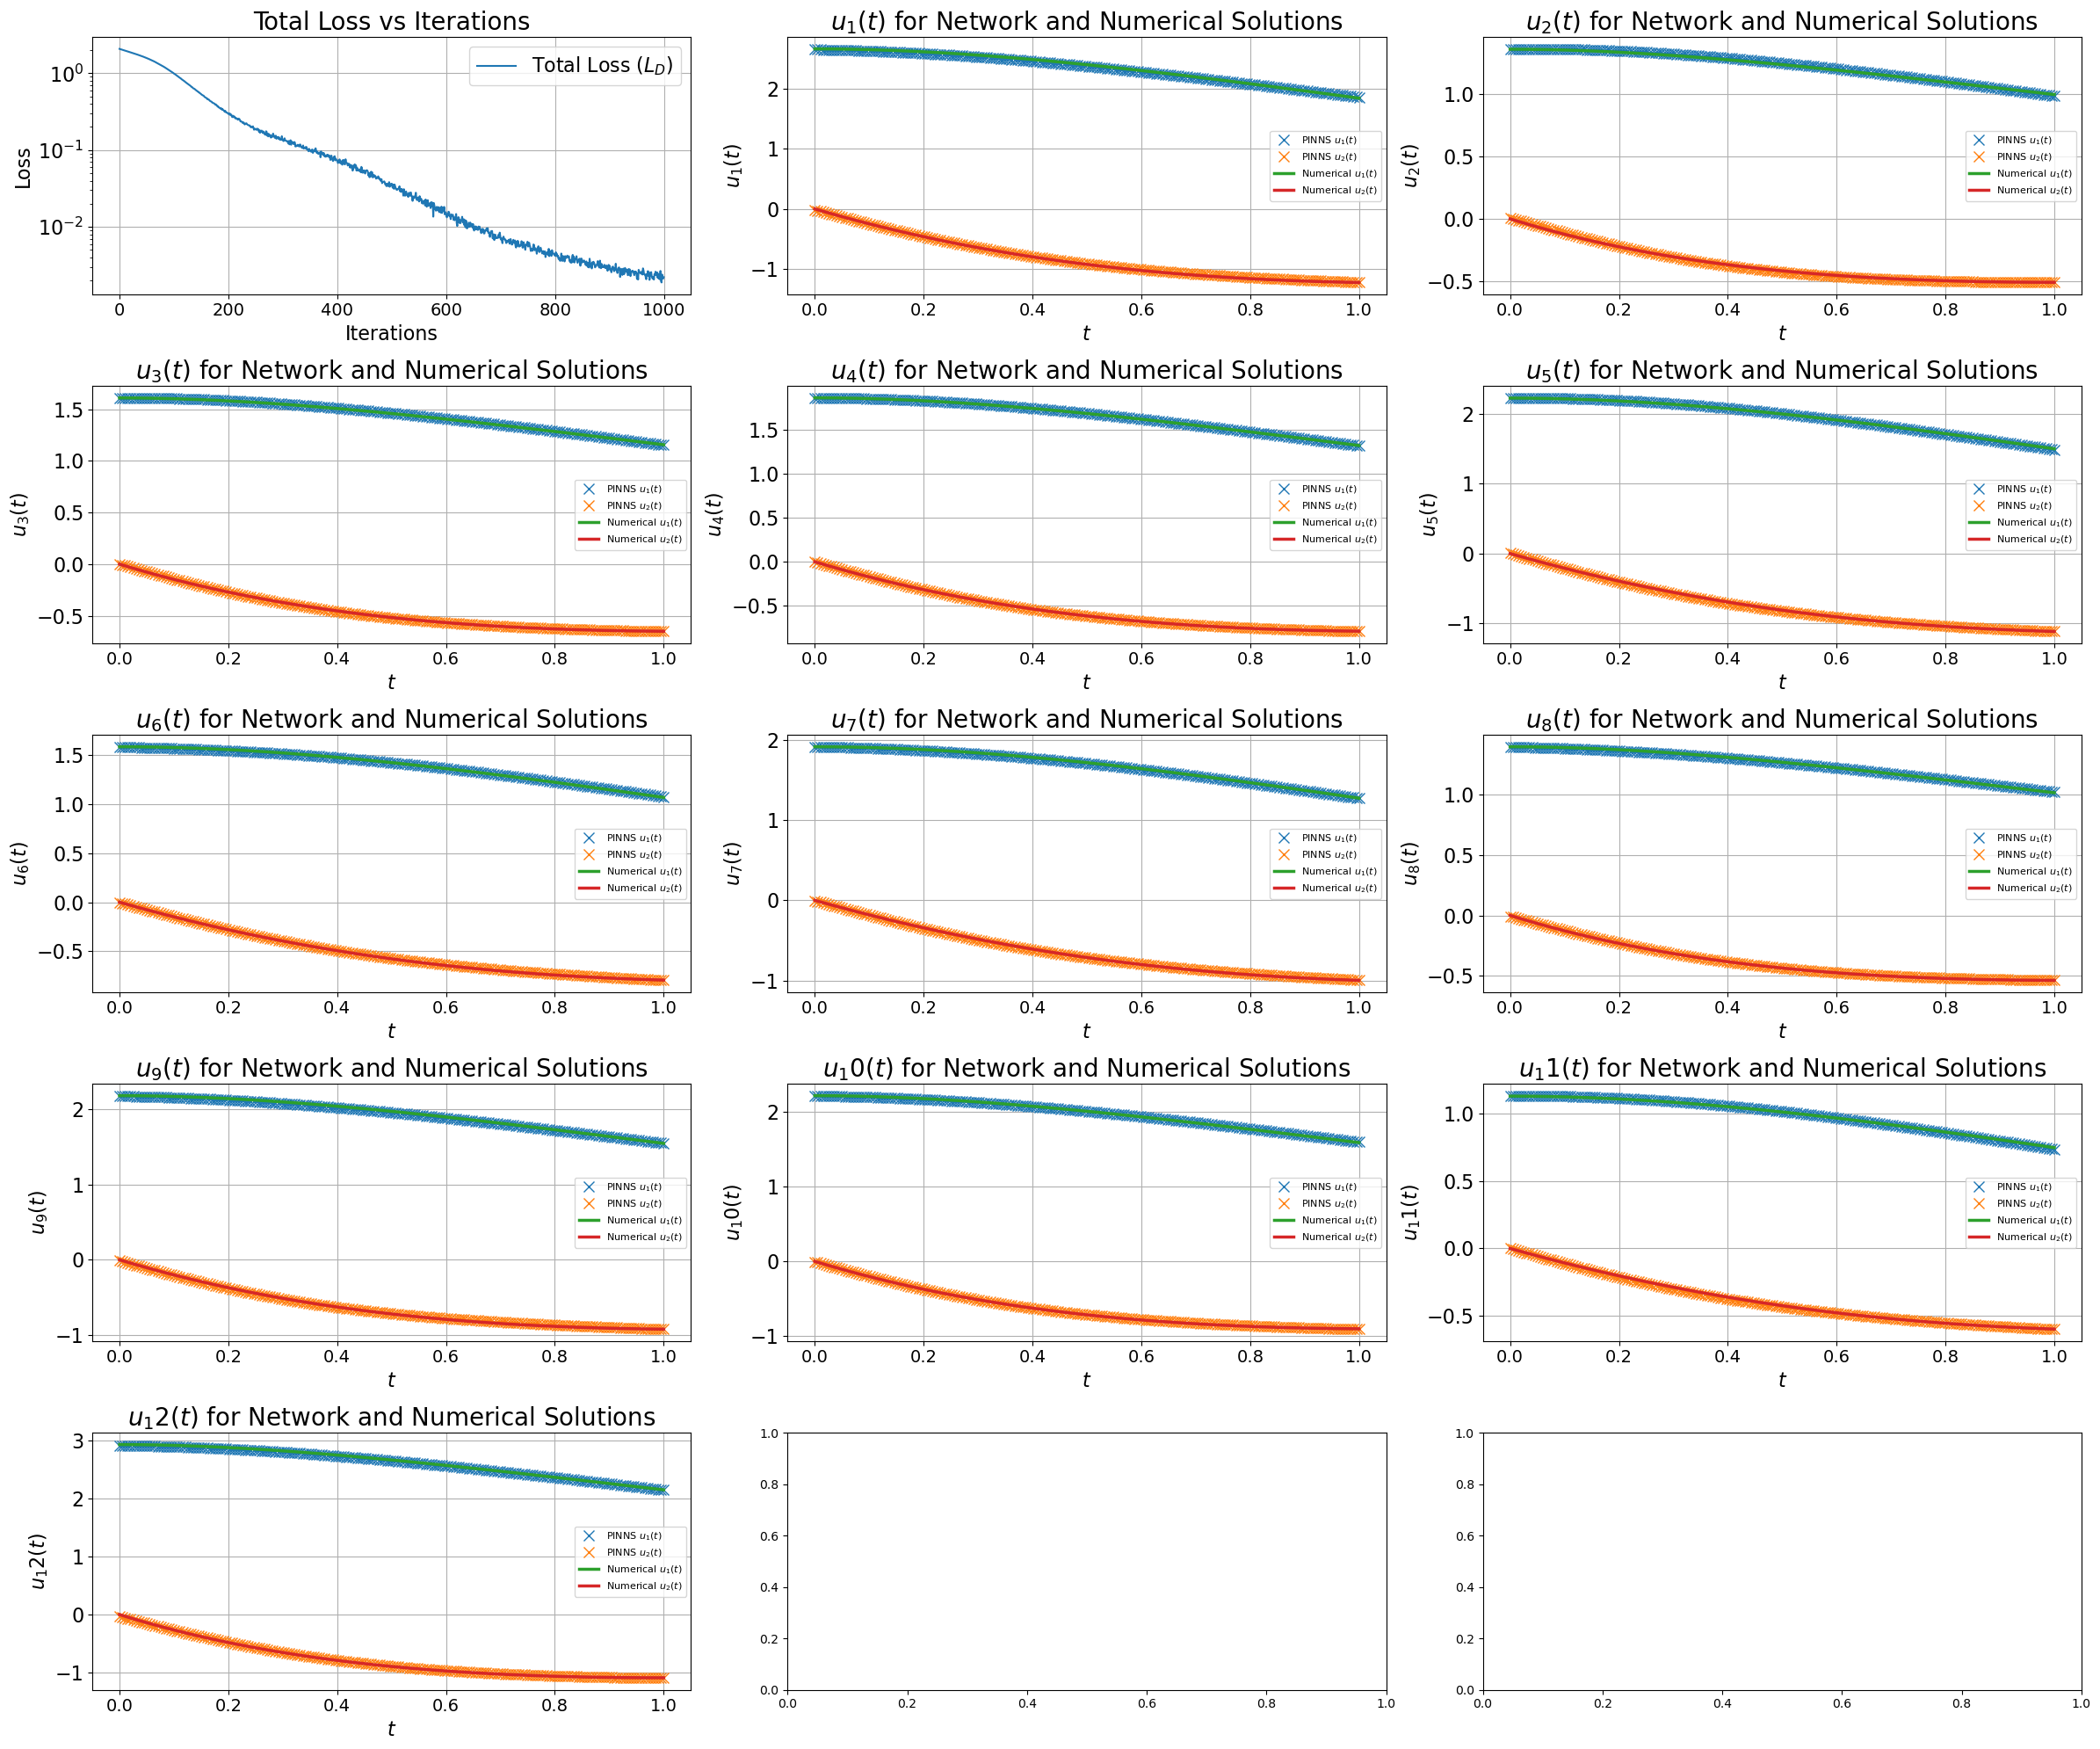

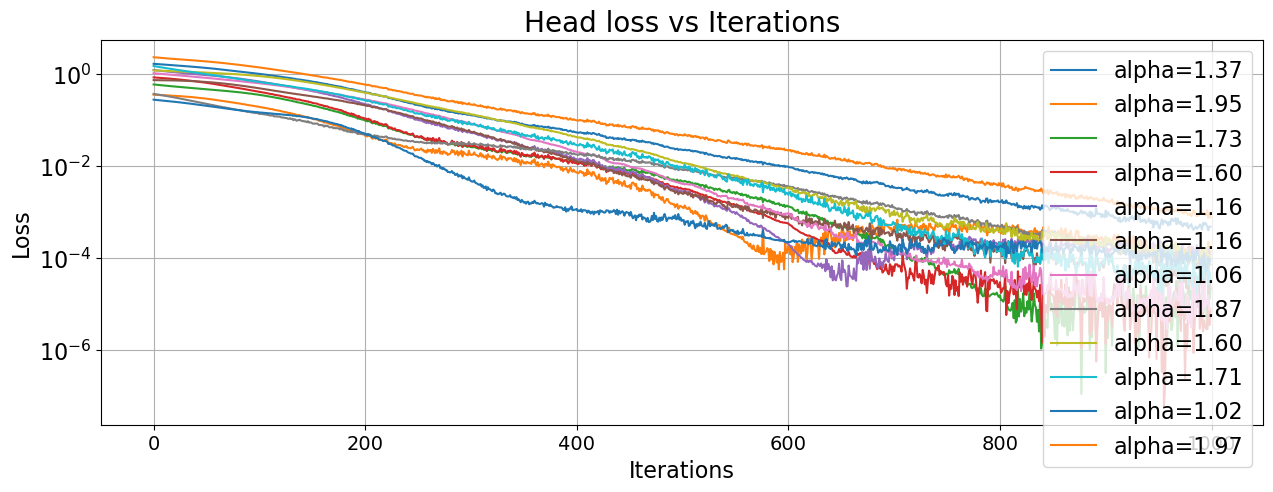

In [12]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)
plot_head_loss(loss_hist["head"], alpha_list)

In [13]:
model_name = "inference"
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, alpha_list, loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/VDP/history_inference_1121514.json
